##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [180]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image segmentation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/segmentation">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/segmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial focuses on the task of image segmentation, using a modified <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external">U-Net</a>.

## What is image segmentation?

In an image classification task, the network assigns a label (or class) to each input image. However, suppose you want to know the shape of that object, which pixel belongs to which object, etc. In this case, you need to assign a class to each pixel of the image—this task is known as segmentation. A segmentation model returns much more detailed information about the image. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging, just to name a few.

This tutorial uses the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) ([Parkhi et al, 2012](https://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf)). The dataset consists of images of 37 pet breeds, with 200 images per breed (~100 each in the training and test splits). Each image includes the corresponding labels, and pixel-wise masks. The masks are class-labels for each pixel. Each pixel is given one of three categories:

- Class 1: Pixel belonging to the pet.
- Class 2: Pixel bordering the pet.
- Class 3: None of the above/a surrounding pixel.

In [181]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-g9ia8gwo
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-g9ia8gwo
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done


In [182]:
import tensorflow as tf

import tensorflow_datasets as tfds

In [183]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Download the Oxford-IIIT Pets dataset

The dataset is [available from TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet). The segmentation masks are included in version 3+.

In [184]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

 In addition, the image color values are normalized to the `[0, 1]` range. Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

In [185]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [186]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [187]:
dataset

{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

The dataset already contains the required training and test splits, so continue to use the same splits:

In [188]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [189]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

The following class performs a simple augmentation by randomly-flipping an image.
Go to the [Image augmentation](data_augmentation.ipynb) tutorial to learn more.


In [190]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

Build the input pipeline, applying the augmentation after batching the inputs:

In [191]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

Visualize an image example and its corresponding mask from the dataset:

In [192]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

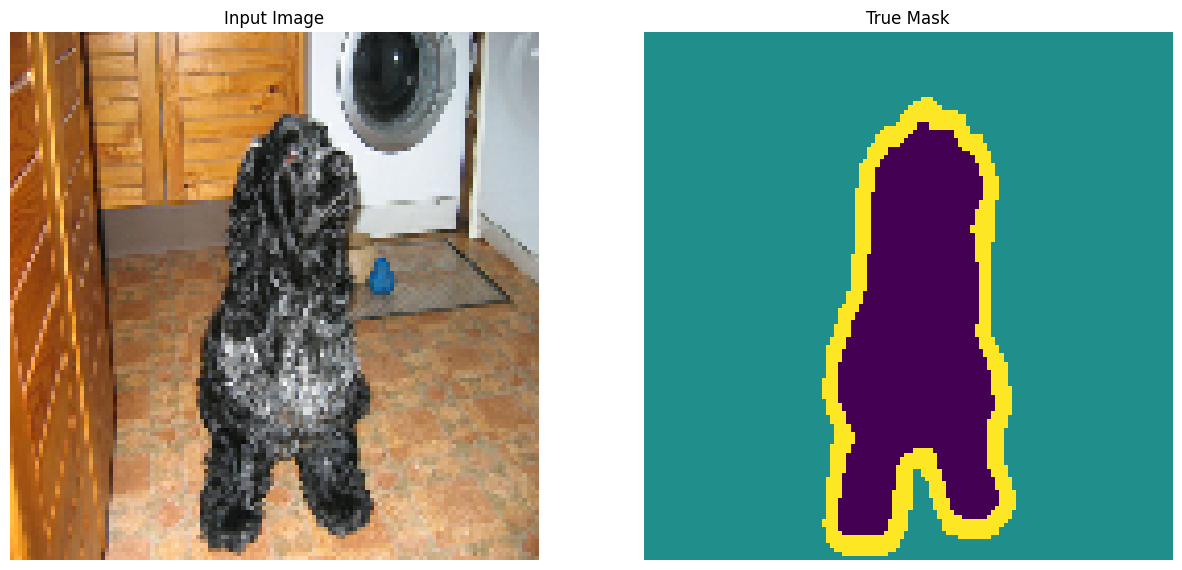

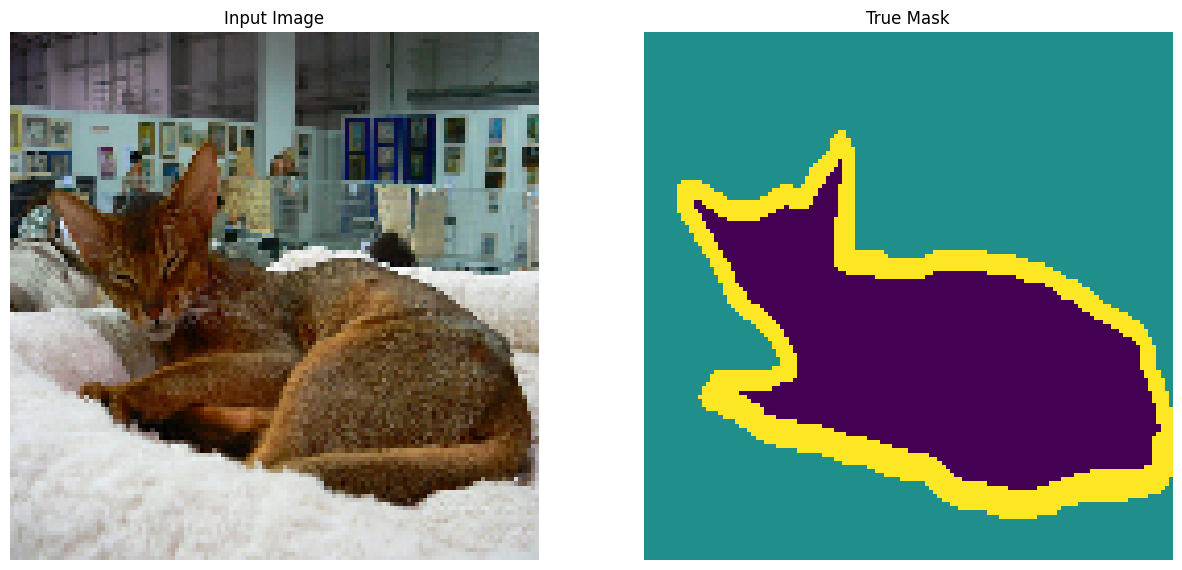

In [272]:
for images, masks in train_batches.take(2):
  #print(images[0].shape,masks[0])
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [278]:
for images, masks in train_batches.take(1):
  print(images[0][20,:,:],masks[0][20,:,:])

tf.Tensor(
[[0.6974186  0.7052617  0.6863743 ]
 [0.70858395 0.71478105 0.69672734]
 [0.68074685 0.67804193 0.655659  ]
 [0.6826567  0.6723226  0.6501319 ]
 [0.660921   0.6491563  0.6217053 ]
 [0.63676494 0.6342321  0.59562415]
 [0.58586377 0.57332695 0.54008096]
 [0.60253906 0.56859297 0.5280599 ]
 [0.7238961  0.68813884 0.6528447 ]
 [0.7801966  0.7652241  0.7337536 ]
 [0.70292586 0.6954609  0.646538  ]
 [0.7308321  0.72052914 0.67527145]
 [0.748269   0.7439355  0.6988528 ]
 [0.7428759  0.74077725 0.6932871 ]
 [0.7304336  0.7376034  0.6920013 ]
 [0.61780524 0.61506325 0.595453  ]
 [0.5354023  0.5729021  0.50647956]
 [0.46530187 0.51375616 0.44962063]
 [0.42248297 0.46837875 0.3828927 ]
 [0.4065461  0.4617154  0.39119872]
 [0.34801337 0.39210707 0.3240639 ]
 [0.48985475 0.5594727  0.5280568 ]
 [0.5044051  0.5791997  0.5365495 ]
 [0.55791086 0.64655596 0.6313716 ]
 [0.5363195  0.6044271  0.5613583 ]
 [0.54212433 0.6390515  0.58723646]
 [0.5057038  0.56296915 0.51299334]
 [0.27999124 0.24

## Define the model
The model being used here is a modified [U-Net](https://arxiv.org/abs/1505.04597). A U-Net consists of an encoder (downsampler) and decoder (upsampler). To learn robust features and reduce the number of trainable parameters, use a pretrained model—[MobileNetV2](https://arxiv.org/abs/1801.04381)—as the encoder. For the decoder, you will use the upsample block, which is already implemented in the [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) example in the TensorFlow Examples repo. (Check out the [pix2pix: Image-to-image translation with a conditional GAN](../generative/pix2pix.ipynb) tutorial in a notebook.)


As mentioned, the encoder is a pretrained MobileNetV2 model. You will use the model from `tf.keras.applications`. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [194]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [195]:
base_model_outputs

[<KerasTensor: shape=(None, 64, 64, 96) dtype=float32 (created by layer 'block_1_expand_relu')>,
 <KerasTensor: shape=(None, 32, 32, 144) dtype=float32 (created by layer 'block_3_expand_relu')>,
 <KerasTensor: shape=(None, 16, 16, 192) dtype=float32 (created by layer 'block_6_expand_relu')>,
 <KerasTensor: shape=(None, 8, 8, 576) dtype=float32 (created by layer 'block_13_expand_relu')>,
 <KerasTensor: shape=(None, 4, 4, 320) dtype=float32 (created by layer 'block_16_project')>]

In [196]:
down_stack.output

[<KerasTensor: shape=(None, 64, 64, 96) dtype=float32 (created by layer 'block_1_expand_relu')>,
 <KerasTensor: shape=(None, 32, 32, 144) dtype=float32 (created by layer 'block_3_expand_relu')>,
 <KerasTensor: shape=(None, 16, 16, 192) dtype=float32 (created by layer 'block_6_expand_relu')>,
 <KerasTensor: shape=(None, 8, 8, 576) dtype=float32 (created by layer 'block_13_expand_relu')>,
 <KerasTensor: shape=(None, 4, 4, 320) dtype=float32 (created by layer 'block_16_project')>]

In [197]:
down_stack.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_9[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']      

The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples:

In [230]:
inputs = tf.keras.layers.Input(shape=[128, 128, 3])
skips1 = down_stack(inputs)
skips1

[<KerasTensor: shape=(None, 64, 64, 96) dtype=float32 (created by layer 'model_3')>,
 <KerasTensor: shape=(None, 32, 32, 144) dtype=float32 (created by layer 'model_3')>,
 <KerasTensor: shape=(None, 16, 16, 192) dtype=float32 (created by layer 'model_3')>,
 <KerasTensor: shape=(None, 8, 8, 576) dtype=float32 (created by layer 'model_3')>,
 <KerasTensor: shape=(None, 4, 4, 320) dtype=float32 (created by layer 'model_3')>]

In [231]:
skips1[:-1]

[<KerasTensor: shape=(None, 64, 64, 96) dtype=float32 (created by layer 'model_3')>,
 <KerasTensor: shape=(None, 32, 32, 144) dtype=float32 (created by layer 'model_3')>,
 <KerasTensor: shape=(None, 16, 16, 192) dtype=float32 (created by layer 'model_3')>,
 <KerasTensor: shape=(None, 8, 8, 576) dtype=float32 (created by layer 'model_3')>]

In [232]:
skip11 = reversed(skips1[:-1])
skip11

In [233]:
skip11_list = list(skip11)

In [237]:
skip11_list

[<KerasTensor: shape=(None, 8, 8, 576) dtype=float32 (created by layer 'model_3')>,
 <KerasTensor: shape=(None, 16, 16, 192) dtype=float32 (created by layer 'model_3')>,
 <KerasTensor: shape=(None, 32, 32, 144) dtype=float32 (created by layer 'model_3')>,
 <KerasTensor: shape=(None, 64, 64, 96) dtype=float32 (created by layer 'model_3')>]

In [238]:
skips1[-1]

<KerasTensor: shape=(None, 4, 4, 320) dtype=float32 (created by layer 'model_3')>

In [239]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [240]:
#xx = up_stack[0](skips1[-1])
#xx

xx = skips1[-1]
xx

<KerasTensor: shape=(None, 4, 4, 320) dtype=float32 (created by layer 'model_3')>

In [241]:
xx1 = up_stack[0](xx)
xx1

<KerasTensor: shape=(None, 8, 8, 512) dtype=float32 (created by layer 'sequential_36')>

In [242]:
skip11_list[0]

<KerasTensor: shape=(None, 8, 8, 576) dtype=float32 (created by layer 'model_3')>

In [243]:
x_x_1 = tf.keras.layers.Concatenate()([xx1, skip11_list[0]])
x_x_1.shape

TensorShape([None, 8, 8, 1088])

In [244]:
xx2 = up_stack[1](x_x_1)
xx2

<KerasTensor: shape=(None, 16, 16, 256) dtype=float32 (created by layer 'sequential_37')>

In [246]:
skip11_list[1]

<KerasTensor: shape=(None, 16, 16, 192) dtype=float32 (created by layer 'model_3')>

In [247]:
x_x_2 = tf.keras.layers.Concatenate()([xx2, skip11_list[1]])
x_x_2.shape

TensorShape([None, 16, 16, 448])

In [248]:
xx3 = up_stack[2](x_x_2)
xx3

<KerasTensor: shape=(None, 32, 32, 128) dtype=float32 (created by layer 'sequential_38')>

In [249]:
skip11_list[2]

<KerasTensor: shape=(None, 32, 32, 144) dtype=float32 (created by layer 'model_3')>

In [250]:
x_x_3 = tf.keras.layers.Concatenate()([xx3, skip11_list[2]])
x_x_3.shape

TensorShape([None, 32, 32, 272])

In [251]:
xx4 = up_stack[3](x_x_3)
xx4

<KerasTensor: shape=(None, 64, 64, 64) dtype=float32 (created by layer 'sequential_39')>

In [252]:
skip11_list[3]

<KerasTensor: shape=(None, 64, 64, 96) dtype=float32 (created by layer 'model_3')>

In [253]:
x_x_4 = tf.keras.layers.Concatenate()([xx4, skip11_list[3]])
x_x_4.shape

TensorShape([None, 64, 64, 160])

In [254]:
import numpy as np
x = np.arange(20).reshape(2, 2, 5)
x

array([[[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9]],

       [[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]]])

In [255]:
y = np.arange(20, 40).reshape(2, 2, 5)
y

array([[[20, 21, 22, 23, 24],
        [25, 26, 27, 28, 29]],

       [[30, 31, 32, 33, 34],
        [35, 36, 37, 38, 39]]])

In [256]:
tf.keras.layers.concatenate([x, y])

<tf.Tensor: shape=(2, 2, 10), dtype=int64, numpy=
array([[[ 0,  1,  2,  3,  4, 20, 21, 22, 23, 24],
        [ 5,  6,  7,  8,  9, 25, 26, 27, 28, 29]],

       [[10, 11, 12, 13, 14, 30, 31, 32, 33, 34],
        [15, 16, 17, 18, 19, 35, 36, 37, 38, 39]]])>

In [257]:
y1 = np.arange(20, 30).reshape(2, 1, 5)
y1

array([[[20, 21, 22, 23, 24]],

       [[25, 26, 27, 28, 29]]])

In [258]:
tf.keras.layers.concatenate([x, y1],axis=1)

<tf.Tensor: shape=(2, 3, 5), dtype=int64, numpy=
array([[[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [20, 21, 22, 23, 24]],

       [[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19],
        [25, 26, 27, 28, 29]]])>

In [259]:
x1 = tf.keras.layers.Dense(8)(np.arange(10).reshape(5, 2))
x2 = tf.keras.layers.Dense(8)(np.arange(10, 20).reshape(5, 2))
concatted = tf.keras.layers.Concatenate()([x1, x2])
concatted.shape

TensorShape([5, 16])

In [260]:
np.arange(10).reshape(5, 2)

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7],
       [8, 9]])

In [270]:
np.arange(75).reshape(5,5,3)

array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11],
        [12, 13, 14]],

       [[15, 16, 17],
        [18, 19, 20],
        [21, 22, 23],
        [24, 25, 26],
        [27, 28, 29]],

       [[30, 31, 32],
        [33, 34, 35],
        [36, 37, 38],
        [39, 40, 41],
        [42, 43, 44]],

       [[45, 46, 47],
        [48, 49, 50],
        [51, 52, 53],
        [54, 55, 56],
        [57, 58, 59]],

       [[60, 61, 62],
        [63, 64, 65],
        [66, 67, 68],
        [69, 70, 71],
        [72, 73, 74]]])

In [271]:
np.arange(25).reshape(5,5,1)

array([[[ 0],
        [ 1],
        [ 2],
        [ 3],
        [ 4]],

       [[ 5],
        [ 6],
        [ 7],
        [ 8],
        [ 9]],

       [[10],
        [11],
        [12],
        [13],
        [14]],

       [[15],
        [16],
        [17],
        [18],
        [19]],

       [[20],
        [21],
        [22],
        [23],
        [24]]])

In [261]:
x1.shape

TensorShape([5, 8])

In [262]:
xd1 = tf.keras.layers.Dense(8)(np.arange(60).reshape(2,3,5, 2))
xd1.shape

TensorShape([2, 3, 5, 8])

In [263]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Note that the number of filters on the last layer is set to the number of `output_channels`. This will be one output channel per class.

## Train the model

Now, all that is left to do is to compile and train the model.

Since this is a multiclass classification problem, use the `tf.keras.losses.SparseCategoricalCrossentropy` loss function with the `from_logits` argument set to `True`, since the labels are scalar integers instead of vectors of scores for each pixel of every class.

When running inference, the label assigned to the pixel is the channel with the highest value. This is what the `create_mask` function is doing.

In [264]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Plot the resulting model architecture:

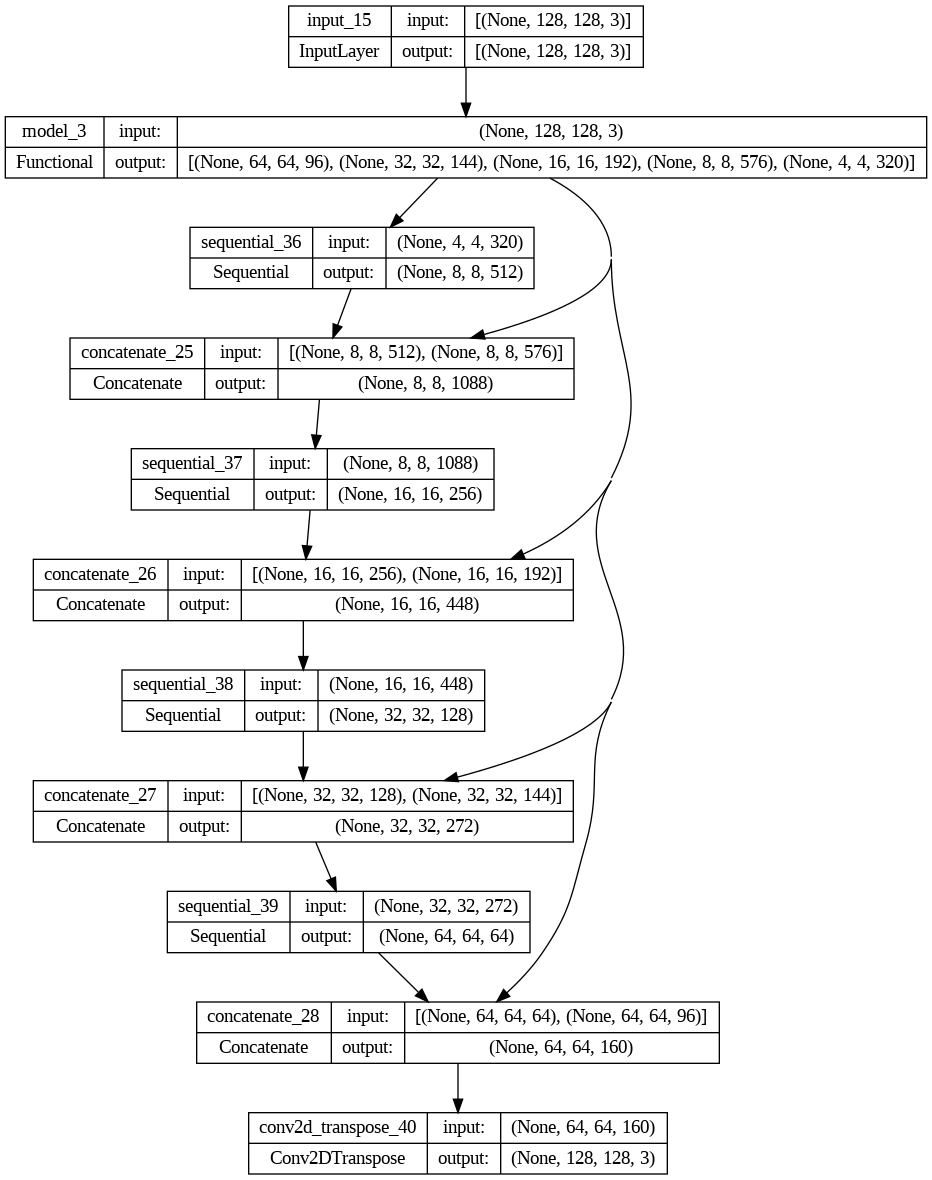

In [265]:
tf.keras.utils.plot_model(model, show_shapes=True)

Try out the model to check what it predicts before training:

In [295]:
def create_mask(pred_mask):
  #print("in pred 1 ",pred_mask.shape)
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  #print("in pred 2 ",pred_mask)
  pred_mask = pred_mask[..., tf.newaxis]
  #print("in pred 3 ",pred_mask.shape)
  return pred_mask[0]

In [293]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 24ms/step
in pred 1  (1, 128, 128, 3)
in pred 2  tf.Tensor(
[[[1 2 1 ... 2 1 2]
  [0 1 0 ... 1 0 1]
  [1 0 1 ... 0 1 1]
  ...
  [0 1 0 ... 1 0 2]
  [1 1 1 ... 1 1 1]
  [2 1 0 ... 1 0 2]]], shape=(1, 128, 128), dtype=int64)
in pred 3  (1, 128, 128, 1)


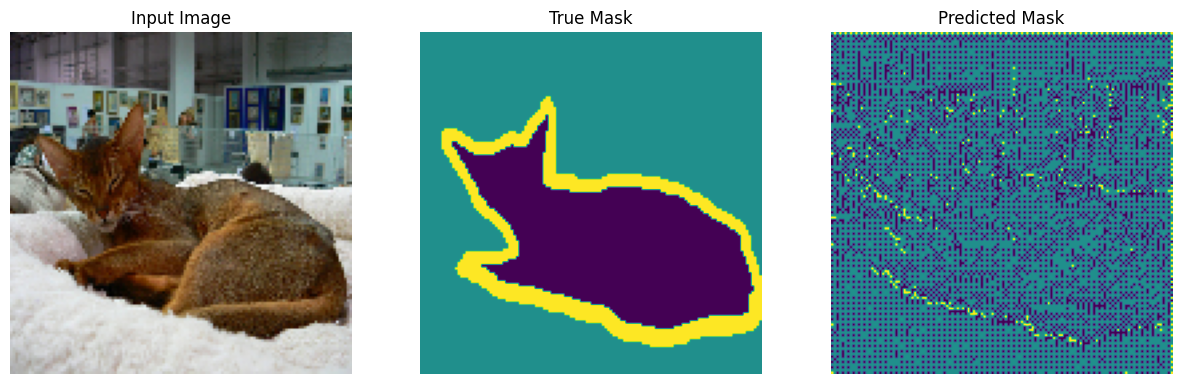

In [294]:
show_predictions()

The callback defined below is used to observe how the model improves while it is training:

In [296]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 22ms/step


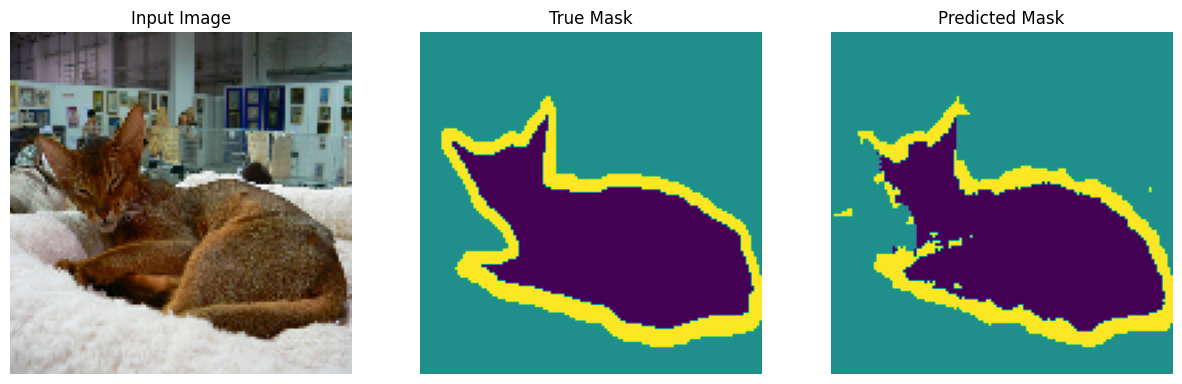


Sample Prediction after epoch 20

57/57 [==============================] - 13s 223ms/step - loss: 0.1767 - accuracy: 0.9278 - val_loss: 0.2696 - val_accuracy: 0.9034


In [297]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

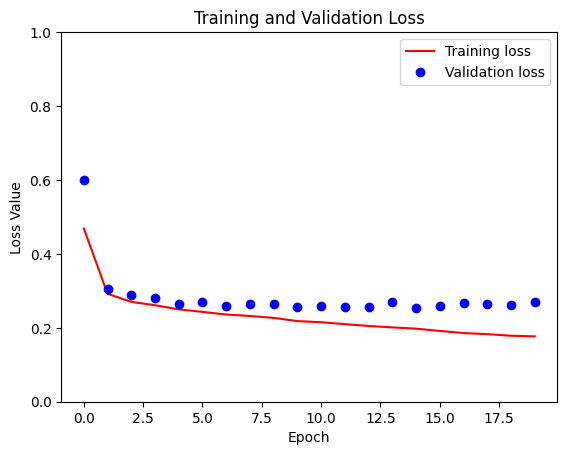

In [298]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Make predictions

Now, make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

2/2 [==============================] - 0s 56ms/step


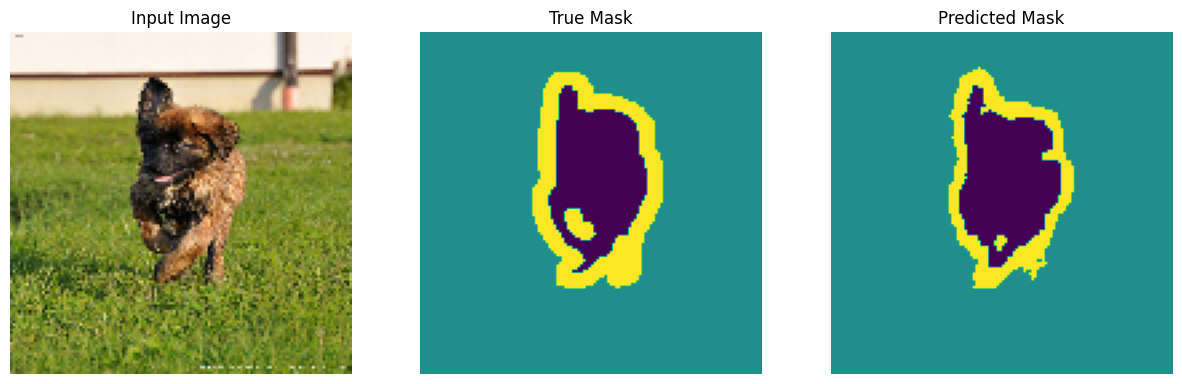

2/2 [==============================] - 0s 50ms/step


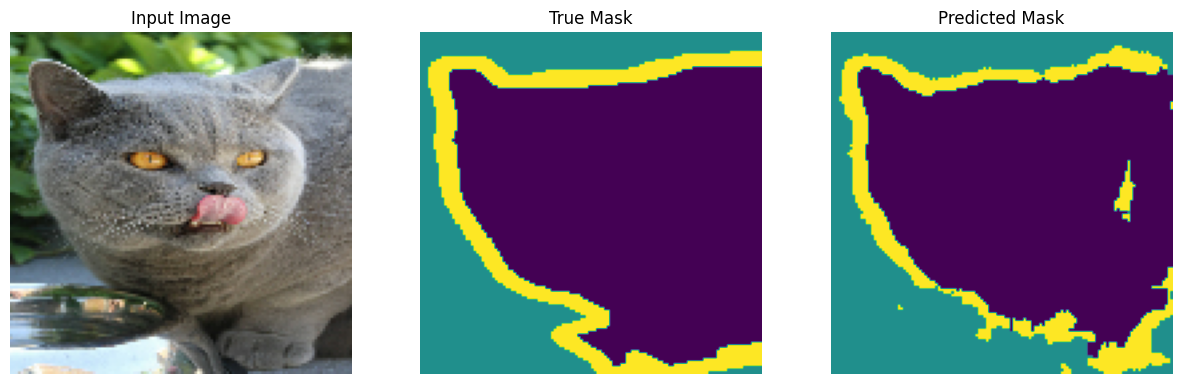

2/2 [==============================] - 0s 39ms/step


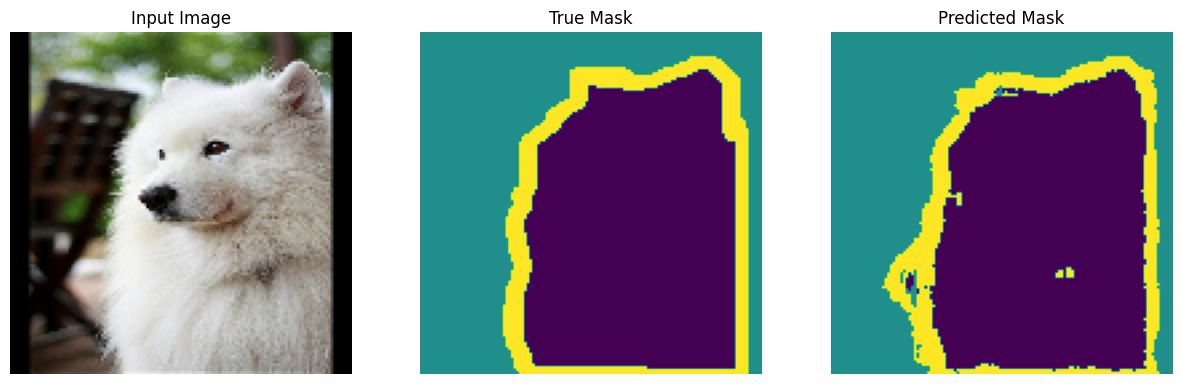

In [299]:
show_predictions(test_batches, 3)

## Optional: Imbalanced classes and class weights

Semantic segmentation datasets can be highly imbalanced meaning that particular class pixels can be present more inside images than that of other classes. Since segmentation problems can be treated as per-pixel classification problems, you can deal with the imbalance problem by weighing the loss function to account for this. It's a simple and elegant way to deal with this problem. Refer to the [Classification on imbalanced data](../structured_data/imbalanced_data.ipynb) tutorial to learn more.

To [avoid ambiguity](https://github.com/keras-team/keras/issues/3653#issuecomment-243939748), `Model.fit` does not support the `class_weight` argument for targets with 3+ dimensions.

In [300]:
try:
  model_history = model.fit(train_batches, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            class_weight = {0:2.0, 1:2.0, 2:1.0})
  assert False
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")

Epoch 1/20
57/57 [==============================] - 9s 128ms/step - loss: 0.2552 - accuracy: 0.9227
Epoch 2/20
57/57 [==============================] - 7s 131ms/step - loss: 0.2578 - accuracy: 0.9219
Epoch 3/20
57/57 [==============================] - 7s 131ms/step - loss: 0.2437 - accuracy: 0.9255
Epoch 4/20
57/57 [==============================] - 7s 124ms/step - loss: 0.2390 - accuracy: 0.9268
Epoch 5/20
57/57 [==============================] - 7s 125ms/step - loss: 0.2255 - accuracy: 0.9300
Epoch 6/20
57/57 [==============================] - 7s 121ms/step - loss: 0.2196 - accuracy: 0.9314
Epoch 7/20
57/57 [==============================] - 7s 122ms/step - loss: 0.2114 - accuracy: 0.9335
Epoch 8/20
57/57 [==============================] - 7s 121ms/step - loss: 0.2070 - accuracy: 0.9347
Epoch 9/20
57/57 [==============================] - 7s 124ms/step - loss: 0.2003 - accuracy: 0.9366
Epoch 10/20
57/57 [==============================] - 7s 121ms/step - loss: 0.1942 - accuracy: 0.9383

So, in this case you need to implement the weighting yourself. You'll do this using sample weights: In addition to `(data, label)` pairs, `Model.fit` also accepts `(data, label, sample_weight)` triples.

Keras `Model.fit` propagates the `sample_weight` to the losses and metrics, which also accept a `sample_weight` argument. The sample weight is multiplied by the sample's value before the reduction step. For example:

In [301]:
label = [0,0]
prediction = [[-3., 0], [-3, 0]]
sample_weight = [1, 10]

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                               reduction=tf.keras.losses.Reduction.NONE)
loss(label, prediction, sample_weight).numpy()

array([ 3.0485873, 30.485874 ], dtype=float32)

So, to make sample weights for this tutorial, you need a function that takes a `(data, label)` pair and returns a `(data, label, sample_weight)` triple where the `sample_weight` is a 1-channel image containing the class weight for each pixel.

The simplest possible implementation is to use the label as an index into a `class_weight` list:

In [302]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([2.0, 2.0, 1.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

The resulting dataset elements contain 3 images each:

In [303]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

Now, you can train a model on this weighted dataset:

In [304]:
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [305]:
weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=1,
    steps_per_epoch=10)

10/10 [==============================] - 5s 125ms/step - loss: 0.3353 - accuracy: 0.5867


## Next steps

Now that you have an understanding of what image segmentation is and how it works, you can try this tutorial out with different intermediate layer outputs, or even different pretrained models. You may also challenge yourself by trying out the [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge/overview) image masking challenge hosted on Kaggle.

You may also want to see the [Tensorflow Object Detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/README.md) for another model you can retrain on your own data. Pretrained models are available on [TensorFlow Hub](https://www.tensorflow.org/hub/tutorials/tf2_object_detection#optional).